In [1]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import provn
import prov_dictionary

3


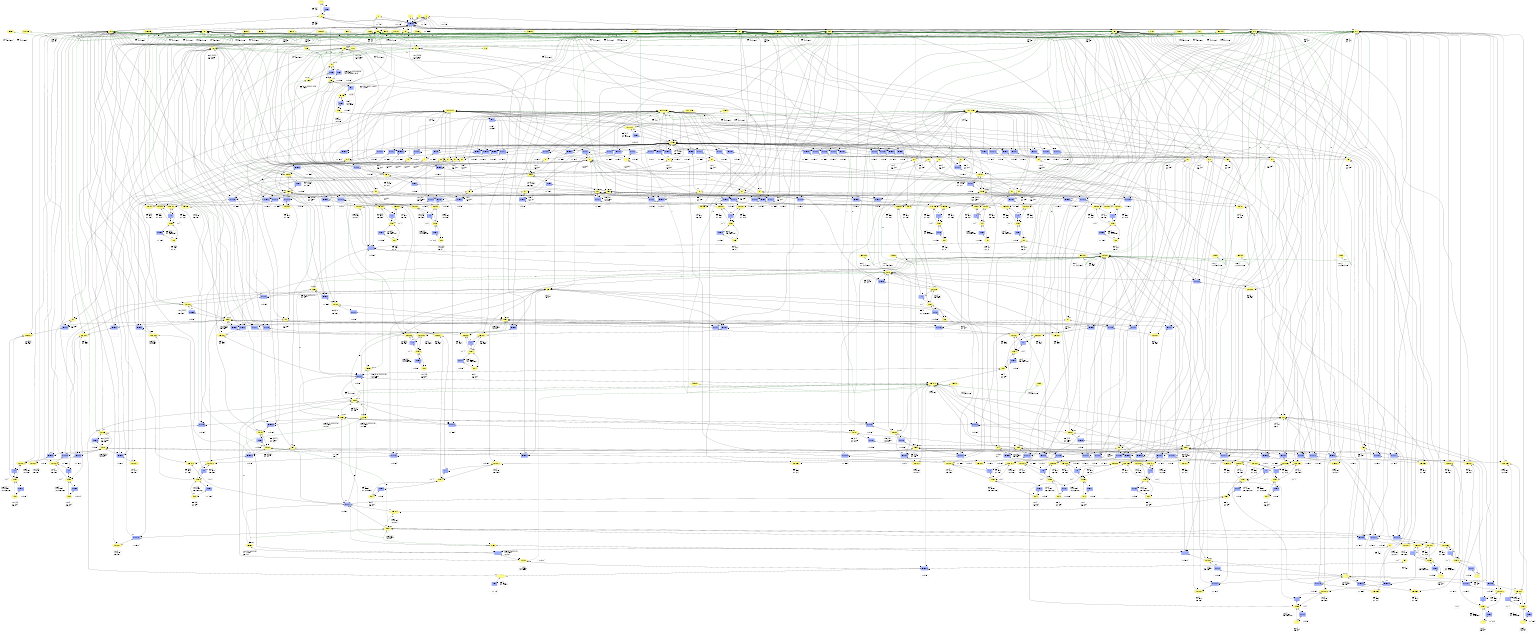

[('used', 488),
 ('entity', 275),
 ('wasDerivedFrom', 244),
 ('wasGeneratedBy', 232),
 ('activity', 212),
 ('derivedByInsertionFrom', 42)]


In [2]:
from pprint import pprint
import importlib
import annotations as prov
importlib.reload(prov)
prov.reset_prov("../images/prov_dictionary/temp/")

def empty(name):
    return prov.entity("e" + name, "[]", "EmptyDictionary", None)
    
# Line 1
m = 10000 # max value

with prov.desc("L1 - assign"):
    e_n10000 = prov.entity("10000", "10000", "literal", None)

    e_m = prov.entity("m", "10000", "name", "10000")
    prov.activity("assign", [(e_m, e_n10000)])


    
# Line 2
result = dist = [
    [0, 1, 4],
    [m, 0, 2],
    [2, m, 0],
]

with prov.desc("L2 - list definition / assign"):
    
    with prov.desc("L2 - list definition"):
        e_n0 = prov.entity("0", "0", "literal", None)
        e_n1 = prov.entity("1", "1", "literal", None)
        e_n2 = prov.entity("2", "2", "literal", None)
        e_n4 = prov.entity("4", "4", "literal", None)

        prov_dist = [
            [e_n0, e_n1, e_n4],
            [e_m, e_n0, e_n2],
            [e_n2, e_m, e_n0],
        ]
        prov_label = [
            ["0", "1", "4"],
            ["m", "0", "2"],
            ["2", "m", "0"]
        ]
        
        e_list, rows = prov.define_array("list", dist, prov_label)
        
        derived = []
        generated = [e_list]
        for i, row in enumerate(rows):
            prov.derivedByInsertionFrom(row[0], empty(row[0]), row[1])
            generated.append(row[0])
            for j, ent in enumerate(row[1]):
                derived.append((ent, prov_dist[i][j]))
        row_ents = [row[0] for row in rows]
        
        prov.derivedByInsertionFrom(e_list, empty("list"), row_ents)

        prov.activity("definelist", derived, generated=generated)
        
    with prov.desc("L2 - assign"):
        e_dist = prov.entity("dist", repr(dist), "Dictionary", "dist")
        prov.derivedByInsertionFrom(e_dist, empty("dist"), row_ents)

        e_result = prov.entity("result", repr(result), "Dictionary", "result")
        prov.derivedByInsertionFrom(e_result, empty("result"), row_ents)

        prov.activity("assign", [(e_dist, e_list)])
        prov.activity("assign", [(e_result, e_list)])

# Line 7
nodes = len(dist)

with prov.desc("L7 - func call / assign"):
    e_ret = prov.entity("len_dist", repr(nodes), "eval", "len(dist)")
    prov.activity("call", [], [e_dist], [e_ret], label="len")
    
    e_nodes = prov.entity("nodes", repr(nodes), "name", "nodes")
    prov.activity("assign", [(e_nodes, e_ret)])


    
# Line 8
indexes = range(nodes)

with prov.desc("L8 - func call / list assign"):
    e_ret = prov.entity("range_nodes", repr(list(indexes)), "eval", "range(nodes)")
    e_items = []
    for i in indexes:
        e_item = prov.entity("range_nodes{}".format(i), str(i), "item", None)
        e_items.append(e_item)
    
    prov.derivedByInsertionFrom(e_ret, empty("range_nodes"), e_items)
    prov.activity("call", [], [e_nodes], [e_ret], label="range")
    
    e_indexes = prov.entity("indexes", repr(list(indexes)), "Dictionary", "indexes")
    prov.derivedByInsertionFrom(e_indexes, empty("indexes"), e_items)

    prov.activity("assign", [(e_indexes, e_ret)])


    
# Line 9
for k in indexes:
    with prov.desc("L9 - loop access"):
        e_k = prov.entity("k", k, "name", "k")
        prov.activity("access", [(e_k, prov.DICTS[e_indexes][repr(k)])], used=[e_indexes])
    
    # Line 10
    distk = dist[k]
    
    with prov.desc("L10 - access / assign"):
    
        e_dist_ak = prov.entity("dist_ak", repr(distk), "Dictionary", "dist[k]")
        
        item = prov.DICTS[e_dist][str(k)]
        elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
        prov.derivedByInsertionFrom(e_dist_ak, empty("dist_ak"), elements)
        
        prov.activity("access", [(e_dist_ak, item)], used=[e_dist, e_k])


        e_distk = prov.entity("distk", repr(distk), "Dictionary", "distk")
        prov.derivedByInsertionFrom(e_distk, empty("distk"), elements)

        prov.activity("assign", [(e_distk, e_dist_ak)])
        
    
    
    # Line 11
    for i in indexes:
        with prov.desc("L11 - loop access"):
            e_i = prov.entity("i", i, "name", "i")
            prov.activity("access", [(e_i, prov.DICTS[e_indexes][repr(i)])], used=[e_indexes])
        
        # Line 12
        disti = dist[i]
        
        with prov.desc("L12 - access / assign"):
            e_dist_ai = prov.entity("dist_ai", repr(disti), "Dictionary", "dist[i]")
            item = prov.DICTS[e_dist][str(i)]
            elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
            prov.derivedByInsertionFrom(e_dist_ai, empty("dist_ai"), elements)

            prov.activity("access", [(e_dist_ai, item)], used=[e_dist, e_i])


            e_disti = prov.entity("disti", repr(disti), "Dictionary", "disti")
            prov.derivedByInsertionFrom(e_disti, empty("disti"), elements)

            prov.activity("assign", [(e_disti, e_dist_ai)])
        
        # Line 13
        for j in indexes:
            with prov.desc("L13 - loop access"):
                e_j = prov.entity("j", j, "name", "j")
                prov.activity("access", [(e_j, prov.DICTS[e_indexes][repr(j)])], used=[e_indexes])
            
            # Line 14
            ikj = disti[k] + distk[j]
            
            with prov.desc("L14 - access / access / operation / assign"):
                e_disti_ak = prov.entity("disti_ak", repr(disti[k]), "access", "disti[k]")
                item = prov.DICTS[e_disti][str(k)]
                prov.activity("access", [(e_disti_ak, item)], used=[e_disti, e_k])
                
                e_distk_aj = prov.entity("distk_aj", repr(distk[j]), "access", "distk[j]")
                item = prov.DICTS[e_distk][str(j)]
                prov.activity("access", [(e_distk_aj, item)], used=[e_distk, e_j])
                
                e_sum = prov.entity("sum", repr(ikj), "operation", "disti[k] + distk[j]")
                prov.activity("+", [(e_sum, e_disti_ak, e_distk_aj)])
                
                e_ikj = prov.entity("ikj", repr(ikj), "name", "ikj")
                prov.activity("assign", [(e_ikj, e_sum)])
               
            
            # Line 15
            with prov.desc("L15 - access"):
                e_disti_aj = prov.entity("disti_aj", repr(disti[j]), "access", "disti[j]")
                item = prov.DICTS[e_disti][str(j)]
                prov.activity("access", [(e_disti_aj, item)], used=[e_disti, e_j])
            
            if disti[j] > ikj:
                
                # Line 16
                disti[j] = ikj
                
                with prov.desc("L16 - part assign with propagation"):
                    used = [e_disti_aj] # from if
                    generated = []
                    e_disti_aj = prov.entity("disti_aj", repr(ikj), "access", "disti[j]")
                    
                    
                    new_e_disti = prov.entity("disti", repr(disti), "Dictionary", "disti")
                    prov.derivedByInsertionFrom(new_e_disti, e_disti, {j: e_disti_aj})
                    used.append(e_disti)
                    generated.append(new_e_disti)
                    
                    new_e_distk = e_distk
                    if i == k:
                        new_e_distk = prov.entity("distk", repr(distk), "Dictionary", "distk")
                        prov.derivedByInsertionFrom(new_e_distk, e_distk, {j: e_disti_aj})
                        used.append(e_distk)
                        generated.append(new_e_distk)
                    
                                     
                    new_e_dist = prov.entity("dist", repr(dist), "Dictionary", "dist")
                    prov.derivedByInsertionFrom(new_e_dist, e_dist, {i: new_e_disti})
                    used.append(e_dist)
                    generated.append(new_e_dist)
                    
                    new_e_result = prov.entity("result", repr(dist), "Dictionary", "result")
                    prov.derivedByInsertionFrom(new_e_result, e_result, {i: new_e_disti})
                    used.append(e_result)
                    generated.append(new_e_result)
                    
                    prov.activity("assign", [(e_disti_aj, e_ikj)], used=used, generated=generated)
                    
                    e_disti = new_e_disti
                    e_distk = new_e_distk
                    e_dist = new_e_dist
                    e_result = new_e_result
                    

# Line 17
print(result[0][2])

with prov.desc("L17 - access / access / call"):
    e_n0 = prov.entity("0", "0", "literal", None)
    e_n2 = prov.entity("2", "2", "literal", None)
    
    e_result_a0 = prov.entity("result_a0", repr(result[0]), "Dictionary", "result[0]")
    item = prov.DICTS[e_result]["0"]
    elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
    prov.derivedByInsertionFrom(e_result_a0, empty("result_a0"), elements)

    prov.activity("access", [(e_result_a0, item)], used=[e_result, e_n0])
    
    e_result_a02 = prov.entity("result_a02", repr(result[0][2]), "access", "result[0][2]")
    item = prov.DICTS[e_result_a0]["2"]
    prov.activity("access", [(e_result_a02, item)], used=[e_result_a0, e_n2])
    
    prov.activity("print", [], [e_result_a02])

pprint(prov.stats("../images/prov_dictionary/floydwarshall", True))